# Investigating one ship case

### run DataCleaning-final.ipynb first

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob
import pykalman
import datetime as dt
from pykalman import KalmanFilter

In [2]:
delta_cur = pd.read_csv("delta_processed.csv",sep='\t',parse_dates=['ReceivedTime'])

In [3]:
user_ID_allowed = np.unique(delta_cur['UserID'])
# As the first try, we choose one ship only
UserID = list(user_ID_allowed)[5]
UserID

218491000

In [4]:
df = delta_cur[delta_cur['UserID']==UserID] #select the single ship
df = df.drop(['UserID','Unnamed: 0'],axis=1)
df = df.sort_values(by=['Time2']).reset_index(drop=True) #sort entries by Time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 7 columns):
ROT             1037 non-null float64
SOG             1037 non-null float64
Longitude       1037 non-null float64
Latitude        1037 non-null float64
TrueHeading     1037 non-null float64
ReceivedTime    1037 non-null datetime64[ns]
Time2           1037 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 56.8 KB


In [5]:
del delta_cur
df.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,ReceivedTime,Time2
0,0.0,19.4,-123.19738,48.40374,35.0,2013-10-31 01:36:58.207,1383183360
1,0.0,19.6,-123.19594,48.40498,35.0,2013-10-31 01:37:15.707,1383183360
2,127.0,17.3,-123.24780,48.68678,6.0,2013-10-31 02:35:31.720,1383186960
3,0.0,18.0,-123.06563,48.75689,55.0,2013-10-31 03:03:51.227,1383188760
4,-126.0,18.6,-123.03533,48.76995,51.0,2013-10-31 03:08:31.810,1383188760


In [6]:
# figure out if the ship leaves the Metro Vancouver
time_diff = np.diff(df['Time2']) #the time between subsequent signals
dfs =[] #here we store dataframe each of them is a part of unique path
idx = 0
#invesgate all cases where the ship was not tracked for an hour or more.
#If ship is near the edge of Metro Vancouver, split path into two parts
#-- we assume that it leaves the Metro Vancouver Area
for i in range(len(time_diff)):
    if time_diff[i]>3600: #1 hour = 60*60=3600 seconds
        #investigate where the ship is located
        lat = df.loc[i,'Latitude']
        lon = df.loc[i,'Longitude']
        #recall original filtering
        #mask = (delta_cur['Longitude']>-127)&(delta_cur['Longitude']<-120)
        #mask = mask & (delta_cur['Latitude']>48)|(delta_cur['Latitude']<50)
        if (lat>-126.8)&(lat<-119.8)&(lon>48.2)&(lon<49.8):
            #the ship is inside Metro Vancouver
            continue
        else:
            dfs.append(df.iloc[idx:i])
            idx = i+1
            
dfs.append(df.loc[idx:])  #append whatever chunk contains the last row          

In [7]:
#how many different paths we got
len(dfs)

2

In [8]:
path_no = 0
df = dfs[path_no] # for now, approximate the one path

In [9]:
#group by time (timedelta = 6 minutes) and compute mean location, ROT, SOG and TrueHeading
def compute_mean(df_t):
    rot =  np.mean(df_t['ROT'])
    sog = np.mean(df_t['SOG'])
    lat = np.mean(df_t['Longitude'])
    lon = np.mean(df_t['Latitude'])
    truehed = np.mean(df_t['TrueHeading'])
    time2 = df_t['Time2'].iloc[0]
    return [rot,sog,lon,lat,truehed,time2]

def process_df(df):
    col_names = df.columns.values.tolist()
    col_names.remove('ReceivedTime')
    df_new = pd.DataFrame(columns = col_names)
    idx = 0 #next index in df_new to be written at
    min_time = np.min(df['Time2'])
    max_time = np.max(df['Time2'])
    for t in range(min_time,max_time+360,360):
        mask = (df['Time2'] == t)
        if np.sum(mask)>0.5: #there is at least one entry
            df_new.loc[idx] = compute_mean(df[mask])
        else:
            df_new.loc[idx] = np.nan
        idx = idx + 1
    return df_new

In [10]:
#process each dataframe in dfs
dfs_new = []
for i in range(len(dfs)):
    dfs_new.append(process_df(dfs[i]))
#The data is ready for approximating paths

In [11]:
#for now, we just focus on a single trip
trip_no = 0
df_new = dfs_new[trip_no]
df_new.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2
0,0.0,19.5,48.40436,-123.19666,35.0,1.383183e+09
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#add horizontal speed and vertical speed
#project SOG on x and y axis using TrueHeading
# 1 lat-lon degree = 60 nautical miles
#which is equivalent to
#1/60 lat or lon degree = 1 nautical mile
# 1 knot = 1 nautical mile per hour
# Therefore,
# 1 knot = 1/60 in lat-lon degrees (along x or y coordinate) per hour
#also note that the angle is with respect to north
df_new['Speed_x'] = df_new['SOG']*df_new['TrueHeading'].apply(lambda x: np.cos(np.deg2rad(x+90)))/(60)
df_new['Speed_y'] = -df_new['SOG']*df_new['TrueHeading'].apply(lambda x: np.sin(np.deg2rad(x+90)))/(60)
#now units of speed is in lat-lon degrees per hour

In [13]:
df_new.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2,Speed_x,Speed_y
0,0.0,19.5,48.40436,-123.19666,35.0,1.383183e+09,-0.186412,-0.266224
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#to feed the data to pykalman we need to mask NaN values
def preprocess_kalman(columns,df_new):
    """
    columns: columns used for pykalman
    df_new: dataframe to process
    """
    mask = df_new[columns].isnull()
    measurements = np.ma.array(np.array(df_new[columns]),mask=mask)
    return measurements
meas = preprocess_kalman(['Longitude','Latitude','Speed_x','Speed_y'],df_new)
print(meas[:5,:])

[[48.40436 -123.19666 -0.18641234181409 -0.2662244143939223]
 [-- -- -- --]
 [-- -- -- --]
 [-- -- -- --]
 [-- -- -- --]]


In [15]:
# True state model
#(x,y,x',y',x'',y'')
from pykalman import KalmanFilter
deltaT = (6/60) #convert minutes to hours
#general formula
#x_new = x + x_vel*deltaT+x_acc*detlaT^2/2
#vel_new = vel + acc*deltaT
#acc_new ~ acc
transition_matrix = np.eye(6)
transition_matrix[0,2] = deltaT
transition_matrix[0,4] = deltaT**2/2
transition_matrix[1,3] = deltaT
transition_matrix[1,5] = deltaT**2/2
transition_matrix[2,4] = deltaT
transition_matrix[3,5] = deltaT
print('Transition matrix')
print(transition_matrix)
observation_matrix= np.zeros((4,6))
observation_matrix[:4,:4] = np.eye(4)
print('Observation matrix')
print(observation_matrix)

Transition matrix
[[ 1.     0.     0.1    0.     0.005  0.   ]
 [ 0.     1.     0.     0.1    0.     0.005]
 [ 0.     0.     1.     0.     0.1    0.   ]
 [ 0.     0.     0.     1.     0.     0.1  ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]
Observation matrix
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]]


In [16]:
initial_state = (df_new.loc[0,'Longitude'],
                df_new.loc[0,'Latitude'],
                df_new.loc[0,'Speed_x'],
                df_new.loc[0,'Speed_y'],
                0,0)
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean=initial_state)

kf = kf.em(meas, n_iter=10)

(filtered_state_means, filtered_state_covariances) = kf.filter(meas)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(meas)

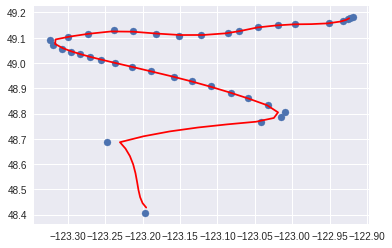

In [19]:
view = df_new[['Latitude','Longitude']].dropna(axis=0)
plt.plot()
plt.scatter(view['Latitude'],view['Longitude'])
plt.plot(smoothed_state_means[1:-1,1],smoothed_state_means[1:-1,0],color='red')
#plt.scatter(smoothed_state_means[-1:,1],smoothed_state_means[-1:,0],color='green')

# Check perfomance on historical data

## Pre-process the data

In [74]:
delta_hist = pd.read_csv('../data/workshop-content18/3-snc/data/PMV_AIS_Deltaport_History.txt',
                 sep='\t', parse_dates=['ReceivedTime'],
                 usecols=['UserID','ROT', 'SOG','Longitude','Latitude',
                          'TrueHeading','ReceivedTime'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
delta_hist = delta_hist.dropna(axis=0)

#extract only lat and lon needed
mask = (delta_hist['Longitude']>-127)&(delta_hist['Longitude']<-120)
mask = mask & (delta_hist['Latitude']>48)|(delta_hist['Latitude']<50)
delta_hist = delta_hist[mask]

# process time into 360 seconds tiles
# 6 minutes = 360 seconds
delta_hist['Time2'] = delta_hist['ReceivedTime'].apply(lambda x: int(360*round(x.timestamp()/360)))

nPoints_by_UserID = pd.value_counts(delta_hist.UserID)
nPoints_threshold = 1000
print('num rows for which userid count <= 1000:', nPoints_by_UserID.loc[nPoints_by_UserID <= 1000].values.sum())
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]

#number of ships selected
print('# ships selected',len(list(userID_allowed)))

delta_hist = delta_hist[delta_hist['UserID'].isin(list(userID_allowed))]

delta_hist.to_csv("delta_hist_processed.csv",sep='\t')

num rows for which userid count <= 1000: 291757
# ships selected 382


## Testing starts

In [76]:
delta_hist = pd.read_csv('delta_hist_processed.csv',sep='\t',parse_dates=['ReceivedTime'],
                 usecols=['UserID', 'ROT','SOG','Longitude','Latitude',
                          'TrueHeading','ReceivedTime','Time2'])


In [77]:
delta_hist.head()

,UserID,ROT,SOG,Longitude,Latitude,TrueHeading,ReceivedTime,Time2
0,316003664,0.0,7.6,-123.06297,49.13173,221.0,2013-08-01 00:00:28.860,1375315200
1,636092306,0.0,0.0,-123.20044,49.30377,314.0,2013-08-01 00:00:29.107,1375315200
2,316005416,-126.0,3.3,-123.01252,49.15289,66.0,2013-08-01 00:00:30.373,1375315200
3,316004333,-127.0,0.0,-123.16602,49.11944,511.0,2013-08-01 00:00:32.640,1375315200
4,316003349,-127.0,0.0,-123.02924,49.29863,511.0,2013-08-01 00:00:32.890,1375315200


In [78]:
#select a ship
ship_list = np.unique(delta_hist['UserID'])
UserID = ship_list[1]
UserID

211776000

In [79]:
df = delta_hist[delta_hist['UserID']==UserID] #select the single ship
df = df.drop(['UserID'],axis=1)
df = df.sort_values(by=['Time2']).reset_index(drop=True) #sort entries by Time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 7 columns):
ROT             2862 non-null float64
SOG             2862 non-null float64
Longitude       2862 non-null float64
Latitude        2862 non-null float64
TrueHeading     2862 non-null float64
ReceivedTime    2862 non-null datetime64[ns]
Time2           2862 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 156.6 KB


In [82]:
# figure out if the ship leaves the Metro Vancouver
time_diff = np.diff(df['Time2']) #the time between subsequent signals
dfs =[] #here we store dataframe each of them is a part of unique path
idx = 0
#invesgate all cases where the ship was not tracked for an hour or more.
#If ship is near the edge of Metro Vancouver, split path into two parts
#-- we assume that it leaves the Metro Vancouver Area
for i in range(len(time_diff)):
    if time_diff[i]>3600: #1 hour = 60*60=3600 seconds
        #investigate where the ship is located
        lat = df.loc[i,'Latitude']
        lon = df.loc[i,'Longitude']
        #recall original filtering
        #mask = (delta_cur['Longitude']>-127)&(delta_cur['Longitude']<-120)
        #mask = mask & (delta_cur['Latitude']>48)|(delta_cur['Latitude']<50)
        if (lat>-126.8)&(lat<-119.8)&(lon>48.2)&(lon<49.8):
            #the ship is inside Metro Vancouver
            continue
        else:
            dfs.append(df.iloc[idx:(i+1)])
            idx = i+1
dfs.append(df.iloc[idx:])#whatever chunk contains the last row 
print('Number of separate paths', len(dfs))

Number of separate paths 7


In [83]:
dfs[0].shape

(617, 7)

In [84]:
#process each dataframe in dfs
dfs_new = []
for i in range(len(dfs)):
    dfs_new.append(process_df(dfs[i]))
#The data is ready for approximating paths

In [86]:
path_no = 0
df = dfs[path_no] # for now, approximate the one path
#for now, we just focus on a single trip
trip_no = 0
df_new = dfs_new[trip_no]
df_new.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2
0,0.0,13.5,48.39951,-123.20574,36.0,1.376626e+09
1,0.0,13.3,48.40412,-123.19944,35.0,1.376626e+09
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,14.4,48.45711,-123.16674,359.0,1.376627e+09
4,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#add horizontal speed and vertical speed
#project SOG on x and y axis using TrueHeading
# 1 lat-lon degree = 60 nautical miles
#which is equivalent to
#1/60 lat or lon degree = 1 nautical mile
# 1 knot = 1 nautical mile per hour
# Therefore,
# 1 knot = 1/60 in lat-lon degrees (along x or y coordinate) per hour
#also note that the angle is with respect to north
df_new['Speed_x'] = df_new['SOG']*df_new['TrueHeading'].apply(lambda x: np.cos(np.deg2rad(x+90)))/(60)
df_new['Speed_y'] = -df_new['SOG']*df_new['TrueHeading'].apply(lambda x: np.sin(np.deg2rad(x+90)))/(60)
#now units of speed is in lat-lon degrees per hour

In [88]:
meas = preprocess_kalman(['Longitude','Latitude','Speed_x','Speed_y'],df_new)
print(meas[:12,:])

[[48.39951 -123.20574 -0.13225168176580643 -0.1820288237343632]
 [48.40412 -123.19944 -0.1271427767244819 -0.1815787031507265]
 [-- -- -- --]
 [48.45711 -123.16674 0.004188577544948069 -0.23996344683753393]
 [-- -- -- --]
 [48.50179 -123.17842 0.06211657082460498 -0.2318221983093764]
 [48.51385 -123.18299 0.06211657082460498 -0.2318221983093764]
 [48.53346 -123.19074 0.06254793589977585 -0.23343207468652485]
 [-- -- -- --]
 [48.58403 -123.21028 0.07166571251241974 -0.24992804094396293]
 [-- -- -- --]
 [-- -- -- --]]


In [89]:
# True state model
#(x,y,x',y',x'',y'')
from pykalman import KalmanFilter
deltaT = (6/60) #convert minutes to hours
#general formula
#x_new = x + x_vel*deltaT+x_acc*detlaT^2/2
#vel_new = vel + acc*deltaT
#acc_new ~ acc
transition_matrix = np.eye(6)
transition_matrix[0,2] = deltaT
transition_matrix[0,4] = deltaT**2/2
transition_matrix[1,3] = deltaT
transition_matrix[1,5] = deltaT**2/2
transition_matrix[2,4] = deltaT
transition_matrix[3,5] = deltaT
print('Transition matrix')
print(transition_matrix)
observation_matrix= np.zeros((4,6))
observation_matrix[:4,:4] = np.eye(4)
print('Observation matrix')
print(observation_matrix)

Transition matrix
[[ 1.     0.     0.1    0.     0.005  0.   ]
 [ 0.     1.     0.     0.1    0.     0.005]
 [ 0.     0.     1.     0.     0.1    0.   ]
 [ 0.     0.     0.     1.     0.     0.1  ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]
Observation matrix
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]]


In [90]:
initial_state = (df_new.loc[0,'Longitude'],
                df_new.loc[0,'Latitude'],
                df_new.loc[0,'Speed_x'],
                df_new.loc[0,'Speed_y'],
                0,0)
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean=initial_state)

kf = kf.em(meas, n_iter=10)

(filtered_state_means, filtered_state_covariances) = kf.filter(meas)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(meas)

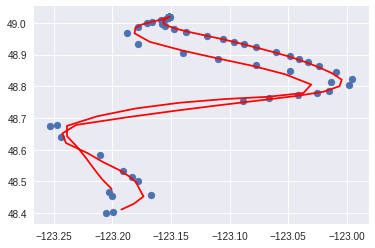

In [91]:
view = df_new[['Latitude','Longitude']].dropna(axis=0)
plt.plot()
plt.scatter(view['Latitude'],view['Longitude'])
plt.plot(smoothed_state_means[1:-1,1],smoothed_state_means[1:-1,0],color='red')
#plt.scatter(smoothed_state_means[-1:,1],smoothed_state_means[-1:,0],color='green')

In [ ]:
#yay!